In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
# read original data from 
data = pd.read_csv('../dataframes/DF_prest.csv', index_col=0)
print('Original Data Shape', data.shape)
# setup 'docs' for use with Tokenizer
def nt_seq_doc(nt_sequence):
    """This function takes in a nucleotide sequence (nt sequence) and adds spaces between each codons.
        It also checks that the sequence is divisible by 3 and that it starts with the expected starting sequence"""
    
    if 'GACAAGCTTGCGGCCGCA' not in nt_sequence:
        return None
    true_nt = nt_sequence.split('GACAAGCTTGCGGCCGCA')[1]
    if len(true_nt) % 3 != 0:
        return None
    return ' '.join([true_nt[i:i+3] 
                     for i in range(0, len(true_nt), 3)])
# split quantiles
def assign_class(conc):
    if conc <= low_cut:
        return 0
    elif conc >= high_cut:
        return 1
    return

data['nt_seq_doc'] = data['nt_seq'].apply(nt_seq_doc)
data = data[pd.notnull(data['nt_seq_doc'])]

# identify high and low classes by conc_cf quantiles
low_cut = data['conc_cf'].quantile(0.25)
high_cut = data['conc_cf'].quantile(0.75)

data['class'] = data['conc_cf'].apply(assign_class)
#Remove entries that are not assigned a class (remove middle quantiles)
data = data[pd.notnull(data['class'])]
# check shape
print('Processed Data Shape: ', data.shape)

Original Data Shape (45206, 6)
Processed Data Shape:  (22364, 8)


In [3]:
def aa_seq_doc(aa_sequence):
    """This function takes in an amino acid sequence (aa sequence) and adds spaces between each amino acid."""
    
    return ' '.join([aa_sequence[i:i+1] 
                     for i in range(0, len(aa_sequence))])

In [4]:
aa_seq_doc(data['aa_seq'][1])

'T Y Y A W K H E L L G S G T C P A L P P R E V L G M E E L E K L P E E Q V A E E E L E C S A L A V S S P G M V L M Q R A K L Y L E H C I S L N T L V P Y R C F K R R F P G I S R S T Y Y N W R R K A L R R N P S F K P A P A L S A A G T P Q L A S V G E G A V I P W K S E A E E G A G N A T G E'

In [5]:
data['aa_seq_doc'] = data['aa_seq'].apply(aa_seq_doc)

In [6]:
list(nt_seq_doc(data['nt_seq'][1])) #is this what the Tokenizer expects? Ask Josh

['A',
 'C',
 'C',
 ' ',
 'T',
 'A',
 'C',
 ' ',
 'T',
 'A',
 'T',
 ' ',
 'G',
 'C',
 'C',
 ' ',
 'T',
 'G',
 'G',
 ' ',
 'A',
 'A',
 'G',
 ' ',
 'C',
 'A',
 'T',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'C',
 'T',
 'G',
 ' ',
 'C',
 'T',
 'G',
 ' ',
 'G',
 'G',
 'C',
 ' ',
 'T',
 'C',
 'T',
 ' ',
 'G',
 'G',
 'C',
 ' ',
 'A',
 'C',
 'C',
 ' ',
 'T',
 'G',
 'C',
 ' ',
 'C',
 'C',
 'G',
 ' ',
 'G',
 'C',
 'C',
 ' ',
 'T',
 'T',
 'G',
 ' ',
 'C',
 'C',
 'C',
 ' ',
 'C',
 'C',
 'C',
 ' ',
 'A',
 'G',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'G',
 'T',
 'G',
 ' ',
 'C',
 'T',
 'G',
 ' ',
 'G',
 'G',
 'C',
 ' ',
 'A',
 'T',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'C',
 'T',
 'A',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'A',
 'A',
 'G',
 ' ',
 'C',
 'T',
 'G',
 ' ',
 'C',
 'C',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'C',
 'A',
 'G',
 ' ',
 'G',
 'T',
 'G',
 ' ',
 'G',
 'C',
 'T',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'G',
 'A',
 'G',
 ' ',
 'C',
 'T',
 'G'

In [8]:
# define sequence documents
docs = list(data['aa_seq_doc'])
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

# integer encode documents
X = t.texts_to_sequences(docs)
y = data['class'].values

# create test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# fix random seed for reproducibility
np.random.seed(7)

# load the dataset but only keep the top n words, zero the rest
top_words = len(t.word_index) + 1

# truncate and pad input sequences
seq_lengths = [len(seq) for seq in X]
max_seq_length = max(seq_lengths)
X_train = sequence.pad_sequences(X_train, maxlen=max_seq_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_seq_length)

# Embed codons, learn w/ single Long Short Term Memory Layer

### 4 dimensional embedding

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 4
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 149, 4)            84        
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 42,185
Trainable params: 42,185
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 107s 7ms/step - loss: 0.6933 - acc: 0.5211
Epoch 2/3
15654/15654 [==============================] - 106s 7ms/step - loss: 0.6703 - acc: 0.5973
Epoch 3/3
15654/15654 [==============================] - 107s 7ms/step - loss: 0.6495 - acc: 0.6273
Accuracy: 62.62%


### 8 dimensional embedding

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 8
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 149, 8)            168       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 43,869
Trainable params: 43,869
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 107s 7ms/step - loss: 0.6864 - acc: 0.5418
Epoch 2/3
15654/15654 [==============================] - 106s 7ms/step - loss: 0.6619 - acc: 0.6056
Epoch 3/3
15654/15654 [==============================] - 106s 7ms/step - loss: 0.6482 - acc: 0.6277
Accuracy: 62.97%


### 16 dimensional embedding

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 149, 16)           336       
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 47,237
Trainable params: 47,237
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 111s 7ms/step - loss: 0.6812 - acc: 0.5611
Epoch 2/3
15654/15654 [==============================] - 110s 7ms/step - loss: 0.6439 - acc: 0.6286
Epoch 3/3
15654/15654 [==============================] - 111s 7ms/step - loss: 0.6351 - acc: 0.6421
Accuracy: 63.77%


### 32 dimensional embedding

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 149, 32)           672       
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 53,973
Trainable params: 53,973
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
15654/15654 [==============================] - 119s 8ms/step - loss: 0.6807 - acc: 0.5616
Epoch 2/3
15654/15654 [==============================] - 119s 8ms/step - loss: 0.6464 - acc: 0.6315
Epoch 3/3
15654/15654 [==============================] - 118s 8ms/step - loss: 0.6363 - acc: 0.6418
Accuracy: 64.08%


# Hook LSTM to basic CNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 149, 16)           336       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 149, 128)          6272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 98,309
Trainable params: 98,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 15654 samples, validate on 6710 samples
Epoch 1/15
15654/15654 [==============================] - 132s 8ms/step - loss: 0.66

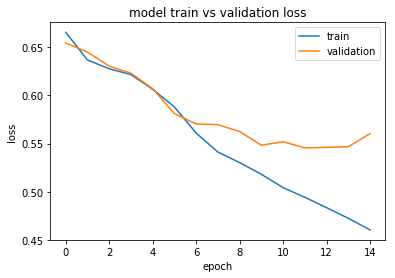

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

# create the model
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# record training progress
history = model.fit(X_train, y_train, epochs=15, batch_size=64,
                    validation_data=(X_test, y_test))

# plot loss vs. epoch
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()